In [1]:
import numpy as np
import cv2
import math
import statistics

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)


def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)


def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)


def region_of_interest(img, vertices):
    """
    Applies an image mask.

    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    # defining a blank mask to start with
    mask = np.zeros_like(img)

    # defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255

    # filling pixels inside the polygon defined by "vertices" with the fill color
    cv2.fillPoly(mask, vertices, ignore_mask_color)

    # returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


class HistoricalLaneDataTracker:
    """
    Track the history of line midpoints and slopes,
    and calculates the mean of the last 60 frames in for additional
    smoothing.
    """
    def __init__(self):
        self.number_of_slopes_to_remember = 60
        self.slopes = []
        self.mean_x_values = []
        self.mean_y_values = []

    def update(self, mean_x, mean_y, mean_slope):
        self.mean_x_values.append(mean_x)
        self.mean_y_values.append(mean_y)
        self.slopes.append(mean_slope)

        if len(self.slopes) > self.number_of_slopes_to_remember:
            self.mean_x_values.pop(0)
            self.mean_y_values.pop(0)
            self.slopes.pop(0)

    def get_latest_lane_data(self):
        return statistics.mean(self.mean_x_values), \
               statistics.mean(self.mean_y_values), \
               statistics.mean(self.slopes)

"""
Global HistoricalLaneDataTrackers for each lane, used in LineProcessors
"""
global_left_lane_slope_holder = HistoricalLaneDataTracker()
global_right_lane_slope_holder = HistoricalLaneDataTracker()


class LineProcessor:
    """
    LineProcessor stores the information (mid coordinate and the slope) regarding to individual lines in a lane,
    in a weighted form, and calculates the mean of all the lines.
    When a line is added, the midpoint and the slope of are multiplied by the length of the line, in order
    for the line to have a fair representation in the final mean line.
    Also, the mean line is passed through the global HistoricalLaneDataTracker, in order to smooth the final line
    according to the history
    """

    def __init__(self, lane_data_tracker):
        self.sum_of_slopes = 0
        self.sum_of_coordinates = (0, 0)
        self.total_length = 0
        self.lane_data_tracker = lane_data_tracker

    @staticmethod
    def weighted_mid_point(a, b, weight):
        return ((a + b) / 2.0) * weight

    def add_line(self, x1, y1, x2, y2, slope):
        """
        Adds a line piece
        :param x1:
        :param y1:
        :param x2:
        :param y2:
        :param slope:
        :return:
        """
        line_length = math.sqrt(math.pow((y2 - y1), 2) + math.pow((x2 - x1), 2))
        self.total_length += line_length
        self.sum_of_slopes += slope * line_length
        self.sum_of_coordinates = (self.sum_of_coordinates[0] +
                                   LineProcessor.weighted_mid_point(x1, x2, line_length),
                                   self.sum_of_coordinates[1] +
                                   LineProcessor.weighted_mid_point(y1, y2, line_length))

    @staticmethod
    def find_x2_from_slope(x1, y1, y2, current_slope):
        return int(x1 - ((y1 - y2) / current_slope))

    def get_mean_line(self, bottom_y, top_y):
        """
        Calculates the weighted mean of all the lines, and returns the mean line after passing it
         through the HistoricalLaneDataTracker for additional smoothing
        :param bottom_y:
        :param top_y:
        :return: bottom_x, bottom_y, top_x, top_y
        """
        if self.total_length != 0:
            self.lane_data_tracker.update(self.sum_of_coordinates[0] / self.total_length,
                                          self.sum_of_coordinates[1] / self.total_length,
                                          self.sum_of_slopes / self.total_length)

        latest_x, latest_y, latest_slope = self.lane_data_tracker.get_latest_lane_data()
        bottom_x = LineProcessor.find_x2_from_slope(latest_x, latest_y, bottom_y, latest_slope)
        top_x = LineProcessor.find_x2_from_slope(latest_x, latest_y, top_y, latest_slope)
        return bottom_x, bottom_y, top_x, top_y


def draw_lines(img, lines, area_of_interest, color=[255, 0, 0], thickness=8):
    left_line_processor = LineProcessor(global_left_lane_slope_holder)
    right_line_processor = LineProcessor(global_right_lane_slope_holder)

    def slope(arg_x1, arg_y1, arg_x2, arg_y2):
        """Calculates the slope of given line"""
        if 0 == arg_x2 - arg_x1:
            return 1
        return (arg_y2 - arg_y1) / (arg_x2 - arg_x1)

    for line in lines:
        for x1, y1, x2, y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, 1)

            current_slope = slope(x1, y1, x2, y2)
            if current_slope < 0.0:
                left_line_processor.add_line(x1, y1, x2, y2, current_slope)
            else:
                right_line_processor.add_line(x1, y1, x2, y2, current_slope)

    """Use the area of interest to get the bottom and top y values for each lane"""
    bottom_left_y = int(area_of_interest[0][0][1])
    top_left_y = int(area_of_interest[0][1][1])
    left_line = left_line_processor.get_mean_line(bottom_left_y, top_left_y)

    bottom_right_y = int(area_of_interest[0][3][1])
    top_right_y = int(area_of_interest[0][2][1])
    right_line = right_line_processor.get_mean_line(bottom_right_y, top_right_y)

    # draw the left lane
    cv2.line(img, (left_line[0], left_line[1]), (left_line[2], left_line[3]), color, thickness)

    # draw the right lane
    cv2.line(img, (right_line[0], right_line[1]), (right_line[2], right_line[3]), color, thickness)


def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap, area_of_interest):
    """
    `img` should be the output of a Canny transform.

    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len,
                            maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines, area_of_interest)
    return line_img


def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.

    `initial_img` should be the image before any processing.

    The result image is computed as follows:

    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

In [2]:
# PIPELINE

In [3]:
def process_image(image):
    processed_image = image.copy()

    # convert to grayscale
    processed_image = grayscale(processed_image)

    # apply Gaussian smoothing
    processed_image = gaussian_blur(processed_image, kernel_size=5)

    # an alternative to using fixed low/high threshold, since the transformation depends
    # on the image content
    # http://www.kerrywong.com/2009/05/07/canny-edge-detection-auto-thresholding/
    image_mean = processed_image.mean(axis=(0, 1))
    low_threshold = image_mean * 0.66
    high_threshold = image_mean * 1.33

    # apply Canny transform
    processed_image = canny(processed_image, low_threshold=low_threshold, high_threshold=high_threshold)

    # filter out the unnecessary bits
    area_of_interest = np.array([[(50, 539), (440, 325), (510, 325), (910, 539)]], dtype=np.int32)
    processed_image = region_of_interest(processed_image, area_of_interest)

    # apply Hough transform
    processed_image = hough_lines(processed_image, rho=1, theta=(math.pi / 180), threshold=15, min_line_len=20,
                                  max_line_gap=10, area_of_interest=area_of_interest)

    # Highlight the lanes and return
    return weighted_img(processed_image, image)

In [4]:
# EXAMPLE RUN 1

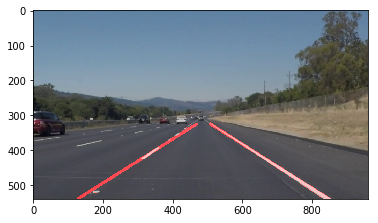

In [5]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

image = mpimg.imread('test_images/solidWhiteRight.jpg')

plt.imshow(process_image(image), cmap='gray')
plt.show()


In [6]:
# EXAMPLE RUN 2

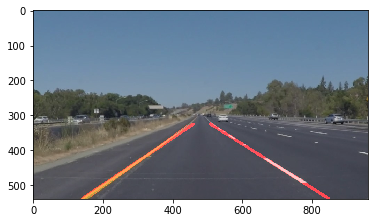

In [7]:
image = mpimg.imread('test_images/solidYellowLeft.jpg')

plt.imshow(process_image(image), cmap='gray')
plt.show()